# Classification Task with Fractional Differencing and Weight Sampling

This notebook is a sort of full pipeline of what we have done in

- Time_Volume_Dollar_Bars.ipynb
- Triple_Barrier_Method_&_CUSUM_Filter.ipynb
- Trend_Following_Strategy_&_MetaLabelling_Classification.ipynb
- Sampling_Weights.ipynb

When also considering the importance of the trade off between time series stationarity and memory --> optimized pipeline with fracdiff

The goal is to obtain a "good" model considering all the techniques and issues threated so bar in terms of trade-offs and optimized statistical properties... Let's begin!

## Libraries & Functions Import

In [193]:
# import libraries

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from scipy.stats import jarque_bera
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#import functions from scripts folder

sys.path.append('../scripts')
from fracdiff import *
from labelling import *
from samp_weights import *
from fin_data_management import * 
from fetch_yf_data import fetch_data
from AFML_book_scripts import *
from AFML_my_scripts import *

## Focus on Fractional Differencing

This is nothing than solveing exercise 5.5 of AFML, some of the results will be used dor ex. 5.6 which will be a bit modified to create the full pipeline we discussed above.

### Prepare Data

In [33]:
# import data 
data = pd.read_csv("../data/SP_futures_tick_data.csv")

In [34]:
#manipulate data such that we can transfomr into a dollar bar series
datetime_str = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(datetime_str, errors='coerce')

,date,time,price,volume,datetime
0,01/03/2000,08:30:34.000,1496.4,0,2000-01-03 08:30:34
1,01/03/2000,08:30:36.000,1496.0,0,2000-01-03 08:30:36
2,01/03/2000,08:30:37.000,1495.5,0,2000-01-03 08:30:37
3,01/03/2000,08:30:46.000,1495.0,0,2000-01-03 08:30:46
4,01/03/2000,08:30:53.000,1495.5,0,2000-01-03 08:30:53


In [35]:
#drop date and time columns
data = data.drop(['date', 'time'], axis=1)

In [206]:
#get the dollar bar dataframe
dollars_bars_size = 1000000  
df = DollarBarsDfVectorized(data, dollar_per_bar=dollars_bars_size)
#check for duplicates
print(df.index[df.index.duplicated()])

Index([], dtype='int64')


In [ ]:
# reindex the dataframe to datetime as we will need timeindexed series objects
df = df.drop('start_date', axis=1 )
df = df.rename(columns={'end_date': 'datetime'})
df = df.set_index('datetime')

In [40]:
#check for duplicates
print(df.index[df.index.duplicated()])

DatetimeIndex(['2003-07-11 06:55:23', '2003-09-05 06:57:16',
               '2003-09-05 06:57:16', '2003-09-05 06:57:16',
               '2003-09-05 06:57:16', '2003-09-05 06:57:16',
               '2003-09-05 06:57:16', '2003-09-05 06:57:16',
               '2003-09-05 06:57:36', '2003-09-11 06:47:48',
               ...
               '2009-07-24 09:48:31', '2009-07-29 16:01:38',
               '2009-08-20 10:08:55', '2009-09-20 18:03:19',
               '2009-09-23 09:26:37', '2009-09-23 09:26:37',
               '2009-10-13 17:08:10', '2009-10-13 17:08:10',
               '2009-10-13 17:08:10', '2009-10-13 17:08:10'],
              dtype='datetime64[ns]', name='datetime', length=309, freq=None)


In [41]:
#remove duplicate indices and check again
df = df[~df.index.duplicated(keep='first')]
print(df.index[df.index.duplicated()])

DatetimeIndex([], dtype='datetime64[ns]', name='datetime', freq=None)


### Form a Cumulative Series and Apply FFD

#### FFD on cumulative Log prices

Text(0.5, 1.0, 'Cumulative Log Price Series')

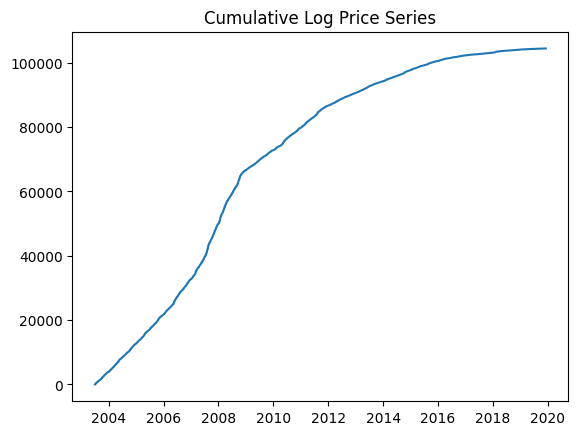

In [44]:
#calculate the cumulative log price series
df['log_price_cumsum'] = np.log(df['close']).cumsum()
plt.plot(df['log_price_cumsum'])
plt.title('Cumulative Log Price Series')    

In [53]:
#apply FFD and find the minium d value that makes the series stationary

#parameters for FFD
d = 0.0
d_max = 2
step = 0.05
tau = 1e-5
#get a series object from log_price_cumsum
original_series = pd.DataFrame(df['log_price_cumsum'], columns=['log_price_cumsum'])

while d <= d_max:
    series_fd = fracDiff_FFD(original_series, d=d, thres=tau)
    series_fd_col = series_fd.log_price_cumsum.dropna()
    
    #skip if the result of afd is empty
    if len(series_fd_col) == 0:
        # skip to next d
        d += step
        continue
    
    result_adf = adfuller(series_fd_col)
    print(f'ADF Statistic for FFD Y with d={round(d,2)}: {round(result_adf[0],4)} with p-value: {round(result_adf[1],4)}')
    
    if result_adf[1] < 0.05:
        print(f'Minimum d to get a p-val below 5% is {round(d,2)}')
        break
    
    d += step


ADF Statistic for FFD Y with d=0.0: 1.3145 with p-value: 0.9967
ADF Statistic for FFD Y with d=0.05: 1.9065 with p-value: 0.9985
ADF Statistic for FFD Y with d=0.1: 1.7679 with p-value: 0.9983
ADF Statistic for FFD Y with d=0.15: 1.5809 with p-value: 0.9978
ADF Statistic for FFD Y with d=0.2: 1.7395 with p-value: 0.9982
ADF Statistic for FFD Y with d=0.25: 1.6191 with p-value: 0.9979
ADF Statistic for FFD Y with d=0.3: 1.7574 with p-value: 0.9983
ADF Statistic for FFD Y with d=0.35: 2.0034 with p-value: 0.9987
ADF Statistic for FFD Y with d=0.4: 2.2131 with p-value: 0.9989
ADF Statistic for FFD Y with d=0.45: 2.529 with p-value: 0.9991
ADF Statistic for FFD Y with d=0.5: 2.8312 with p-value: 1.0
ADF Statistic for FFD Y with d=0.55: 3.1426 with p-value: 1.0
ADF Statistic for FFD Y with d=0.6: 3.3739 with p-value: 1.0
ADF Statistic for FFD Y with d=0.65: 3.4598 with p-value: 1.0
ADF Statistic for FFD Y with d=0.7: 3.6183 with p-value: 1.0
ADF Statistic for FFD Y with d=0.75: 3.7112 with 

A cumulative series or prices is extremely non-stationary --> FFD is not able to solve the issue

Let's apply it on returns

#### FFD on log prices


Text(0.5, 1.0, 'Log Price Series')

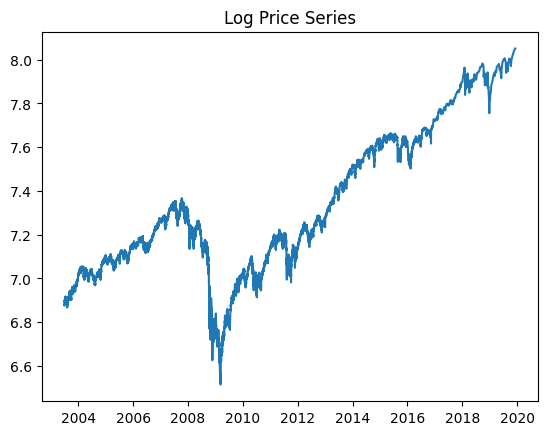

In [88]:
#calculate the cumulative log price series
df['log_price'] = np.log(df['close'])
plt.plot(df['log_price'])
plt.title('Log Price Series')    

In [ ]:
#apply FFD and find the minium d value that makes the series stationary

#parameters for FFD
d = 0.0
d_max = 2
step = 0.05
tau = 1e-5
#get a series object from log_price_cumsum
original_series = pd.DataFrame(df['log_price'], columns=['log_price'])

In [90]:
while d <= d_max:
    series_fd = fracDiff_FFD(original_series, d=d, thres=tau)
    series_fd_col = series_fd.log_price.dropna()
    
    #skip if the result of afd is empty
    if len(series_fd_col) == 0:
        # skip to next d
        d += step
        continue
    
    result_adf = adfuller(series_fd_col)
    print(f'ADF Statistic for FFD Y with d={round(d,2)}: {round(result_adf[0],4)} with p-value: {round(result_adf[1],4)}')
    
    if result_adf[1] < 0.05:
        print(f'Minimum d to get a p-val below 5% is {round(d,2)}')
        break
    
    d += step

d_optimal = d

ADF Statistic for FFD Y with d=0.0: 1.2212 with p-value: 0.9961
ADF Statistic for FFD Y with d=0.05: 0.814 with p-value: 0.9919
ADF Statistic for FFD Y with d=0.1: 0.3492 with p-value: 0.9795
ADF Statistic for FFD Y with d=0.15: -0.2082 with p-value: 0.9375
ADF Statistic for FFD Y with d=0.2: -0.8691 with p-value: 0.798
ADF Statistic for FFD Y with d=0.25: -1.5863 with p-value: 0.4905
ADF Statistic for FFD Y with d=0.3: -2.3953 with p-value: 0.1431
ADF Statistic for FFD Y with d=0.35: -3.2389 with p-value: 0.0178
Minimum d to get a p-val below 5% is 0.35


Prices are non-stationary as well (cumulative log price have one extra order of integration --> extremely non stationary) --> FFD is able to stationarize with d = 0.35

Now we can check if memory has been preserved by computing the correlation

In [92]:
print(f'The min d to pass ADF test is {d_optimal}')

The min d to pass ADF test is 0.35


In [93]:
original_series

,log_price
datetime,
2003-07-01 03:16:58.000,6.879253
2003-07-01 06:32:13.000,6.878635
2003-07-01 07:44:30.000,6.875335
2003-07-01 16:25:20.000,6.889795
2003-07-02 01:51:56.000,6.890813
...,...
2019-10-08 17:29:47.032,7.970222
2019-10-14 03:01:58.578,7.995239
2019-10-29 20:10:53.206,8.017736


In [98]:
#perform FFD with d_min such that ADF is passed
series_fd = fracDiff_FFD(original_series, d=d_optimal, thres=tau)
series_fd


,log_price
2005-01-03 03:15:05.000,0.382314
2005-01-03 05:18:33.000,0.380750
2005-01-03 08:08:09.000,0.379980
2005-01-04 02:06:03.000,0.370236
2005-01-04 03:46:05.000,0.375211
...,...
2019-10-08 17:29:47.032,0.432891
2019-10-14 03:01:58.578,0.465842
2019-10-29 20:10:53.206,0.481399
2019-11-21 04:07:51.275,0.495591


In [102]:
series_fd_values = series_fd.log_price.dropna()
original_series_values = original_series.loc[series_fd_values.index,'log_price']
correlation = original_series_values.corr(series_fd_values)
print(f"Correlation between FFD series (d={d_optimal}) and original series: {correlation:.4f}")

Correlation between FFD series (d=0.35) and original series: 0.8390


A correlation of ~0.84 is not bad at all. This means that fractionally differencing with an order of d = 0.35 makes the series stationary while preserving quite a lot of the information (memory) that would otherwise being lost if fully fractioning.

In [79]:
correlation_full_frac = df.log_price.corr(df.log_price.diff())

print(f"Correlation between FFD series and original series: {correlation_full_frac:.4f}")

Correlation between FFD series and original series: 0.0321


As you can see when fully fractionind (d=1) the correlation drops almost to zero --> all the stochastic memory is erased!

### Cointegration Test

In [103]:
coint_stat, p_val, crit_val = coint(series_fd_values,original_series_values)
print(f"Engle-Granger test statistic: {coint_stat:.4f}, p-value: {p_val:.4f}")
print("Critical values:", crit_val)

Engle-Granger test statistic: -7.5411, p-value: 0.0000
Critical values: [-3.89730073 -3.33661013 -3.04478326]


Yes, the Engle–Granger test suggests cointegration between the log price and its FFD transform. This is expected, since the FFD retains long-memory dependence on the original series while removing non-stationarity. However, this is not classical cointegration between two I(1) series, but rather a by-product of the construction of FFD

### Normality Test

In [105]:
# Jarque-Bera test on fracdiff series
jb_stat, jb_pval = jarque_bera(series_fd_values)

print(f"Jarque-Bera statistic: {jb_stat:.4f}, p-value: {jb_pval:.4f}")

if jb_pval < 0.05:
    print("Reject null hypothesis: fracdiff series is NOT normally distributed.")
else:
    print("Fail to reject null hypothesis: fracdiff series is consistent with normality.")


Jarque-Bera statistic: 10760.0252, p-value: 0.0000
Reject null hypothesis: fracdiff series is NOT normally distributed.


- The Jarque-Bera test checks whether the FFD series is normally distributed.
- Typically, financial return series are not perfectly Gaussian but exhibit fat tails and skewness.
- Rejecting normality here is expected and desirable, as it indicates the FFD series retains realistic market behavior.


## Frac Diff Classification Pipeline

This exercise actually summarizes a lot of studies we have performed so far.

We proceed as follows:

1. From tick data form dollar bars to improve stat. properties of data
2. Use fractional differencing to make the close price series stationary but keep the memory 
3. Apply a cusum filter to get relevant events 
4. Use TBM to get events and labels
5. Create a feature Matrix and boostrap observatios using sequential boostrap to solve for coevents. On top of this on each bootstrap sample using sample weights adjusted for concurrency
6. Fit a bagging classififer with base decision tree using the samples and weights found a point 5
7. Check predictive performances

### Get dollars bar data

In [262]:
# import data 
data = pd.read_csv("../data/SP_futures_tick_data.csv")
#manipulate data such that we can transfomr into a dollar bar series
datetime_str = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(datetime_str, errors='coerce')
#drop date and time columns
data = data.drop(['date', 'time'], axis=1)
#get the dollar bar dataframe
dollars_bars_size = 1000000  
df = DollarBarsDfVectorized(data, dollar_per_bar=dollars_bars_size)
#check for duplicates
print(df.index[df.index.duplicated()])
# reindex the dataframe to datetime as we will need timeindexed series objects
df = df.drop('start_date', axis=1 )
df = df.rename(columns={'end_date': 'datetime'})
df = df.set_index('datetime')
#remove duplicate indices and check again
df = df[~df.index.duplicated(keep='first')]
print(df.index[df.index.duplicated()])

Index([], dtype='int64')
DatetimeIndex([], dtype='datetime64[ns]', name='datetime', freq=None)


### Apply Frac Diff

In [263]:
#starting from the dollard bars data
print(df.shape)
df.head()

(14553, 6)


,open,high,low,close,volume,dollar_volume
datetime,,,,,,
2003-07-01 03:16:58,1496.4,1574.0,767.5,971.9,1031,1003316.0
2003-07-01 06:32:13,972.0,973.2,971.1,971.3,1030,1001129.9
2003-07-01 07:44:30,971.3,972.0,967.6,968.1,1032,1001141.2
2003-07-01 16:25:20,968.0,982.4,960.5,982.2,1024,994588.6
2003-07-02 01:51:56,982.3,984.0,981.3,983.2,1026,1008342.4


In [264]:
#apply frac diff using the minium d
#apply FFD and find the minium d value that makes the series stationary

#parameters for FFD
d = 0.0
d_max = 2
step = 0.05
tau = 1e-5
#get a series object from log_price_cumsum
close = pd.DataFrame(df['close'], columns=['close'])

In [265]:
while d <= d_max:
    series_fd = fracDiff_FFD(close, d=d, thres=tau)
    series_fd_col = series_fd.close.dropna()
    
    #skip if the result of afd is empty
    if len(series_fd_col) == 0:
        # skip to next d
        d += step
        continue
    
    result_adf = adfuller(series_fd_col)
    print(f'ADF Statistic for FFD Y with d={round(d,2)}: {round(result_adf[0],4)} with p-value: {round(result_adf[1],4)}')
    
    if result_adf[1] < 0.05:
        print(f'Minimum d to get a p-val below 5% is {round(d,2)}')
        break
    
    d += step

d_optimal = d

ADF Statistic for FFD Y with d=0.0: 3.8319 with p-value: 1.0
ADF Statistic for FFD Y with d=0.05: 2.9918 with p-value: 1.0
ADF Statistic for FFD Y with d=0.1: 2.4624 with p-value: 0.999
ADF Statistic for FFD Y with d=0.15: 1.8271 with p-value: 0.9984
ADF Statistic for FFD Y with d=0.2: 1.0436 with p-value: 0.9947
ADF Statistic for FFD Y with d=0.25: 0.3406 with p-value: 0.9791
ADF Statistic for FFD Y with d=0.3: -0.4371 with p-value: 0.9037
ADF Statistic for FFD Y with d=0.35: -1.2822 with p-value: 0.6373
ADF Statistic for FFD Y with d=0.4: -2.2211 with p-value: 0.1987
ADF Statistic for FFD Y with d=0.45: -3.2143 with p-value: 0.0192
Minimum d to get a p-val below 5% is 0.45


In [266]:
print(f'The min d to pass ADF test is {round(d_optimal,3)}')

The min d to pass ADF test is 0.45


In [267]:
#perform FFD with d_min such that ADF is passed
close_fdd = fracDiff_FFD(close, d=d_optimal, thres=tau)
close_fdd


,close
2004-06-16 02:44:09.000,33.867211
2004-06-16 03:49:54.000,35.656257
2004-06-16 06:12:44.000,33.370092
2004-06-16 08:11:37.000,31.002105
2004-06-17 02:27:17.000,31.868387
...,...
2019-10-08 17:29:47.032,69.578559
2019-10-14 03:01:58.578,174.583859
2019-10-29 20:10:53.206,215.624445
2019-11-21 04:07:51.275,253.102827


In [269]:
fdd_series = close_fdd.close.dropna()
original_series = close.loc[close.index,'close']
correlation = original_series.corr(fdd_series)
print(f"Correlation between FFD series (d={round(d_optimal,2)}) and original series: {correlation:.4f}")

Correlation between FFD series (d=0.45) and original series: 0.7503


The correlation is not the best but we achieved stationarity

In [230]:
#align starting df with fdd series
df = df.loc[close_fdd.index]
df['fdd'] = close_fdd
df

,open,high,low,close,volume,dollar_volume,fdd
2004-06-16 02:44:09.000,1132.6,1134.7,1132.2,1133.9,881,998563.7,33.867211
2004-06-16 03:49:54.000,1133.9,1136.6,1133.2,1136.4,881,1000119.7,35.656257
2004-06-16 06:12:44.000,1136.4,1137.0,1135.3,1135.5,880,999822.3,33.370092
2004-06-16 08:11:37.000,1135.4,1135.6,1133.0,1133.2,882,1000457.8,31.002105
2004-06-17 02:27:17.000,1133.2,1135.4,1130.1,1133.2,883,999672.8,31.868387
...,...,...,...,...,...,...,...
2019-10-08 17:29:47.032,2973.3,2992.0,2856.0,2893.5,341,998716.1,69.578559
2019-10-14 03:01:58.578,2893.5,2992.5,2883.9,2966.8,344,1005621.3,174.583859
2019-10-29 20:10:53.206,2966.8,3044.0,2956.4,3034.3,332,994846.1,215.624445
2019-11-21 04:07:51.275,3032.5,3132.0,3025.0,3108.8,324,999676.2,253.102827


### CUSUM FILTER

In [ ]:
std = df.fdd.std()
h = 2*std
cusum_events = get_CUSUM_events(df.fdd,h)
cusum_events

DatetimeIndex([       '2004-11-04 16:13:17',        '2005-04-14 16:02:01',
                      '2005-07-07 15:53:09',        '2006-03-14 15:58:58',
                      '2006-06-15 19:23:33',        '2007-02-27 15:57:57',
                      '2007-02-28 00:43:41',        '2007-03-08 15:42:01',
                      '2007-03-13 17:05:05',        '2007-03-21 15:37:51',
               ...
               '2019-08-07 07:35:00.274000', '2019-08-15 06:33:13.172000',
               '2019-08-21 17:16:16.069000', '2019-08-25 19:51:50.873000',
               '2019-08-28 03:46:51.600000', '2019-09-04 02:48:01.849000',
               '2019-09-30 02:51:35.303000', '2019-10-08 17:29:47.032000',
               '2019-10-14 03:01:58.578000', '2019-10-29 20:10:53.206000'],
              dtype='datetime64[ns]', length=445, freq=None)

### Feature Matrix

In [ ]:
#drop non useful columns 
df = df.drop(['open', 'high', 'low'],axis =1)
#align df with cusum filter events to use it as feature matrix
df = df.loc[cusum_events]
#create some extra features
window = 5  
df['rolling_mean'] = df['fdd'].rolling(window).mean()
df['rolling_std'] = df['fdd'].rolling(window).std()
df['returns'] = df['fdd'].pct_change()


### TBM

In [243]:
ptSL = (1,1)
min_ret = df['close'].pct_change().mean()
target = GetTargetforTBM(df.close,ema_periods=window)
numDays = 5
close = df.close

t1=df.close.index.searchsorted(cusum_events+pd.Timedelta(days=numDays))
t1=t1[t1<df.close.shape[0]]
t1=pd.Series(df.close.index[t1],index=cusum_events[:t1.shape[0]])

In [244]:
#get events
events = getEventsMeta(df.close,cusum_events,ptSL,target,min_ret,t1)
events

,t1,trgt,side,hit_first
2004-11-04 16:13:17.000,2005-04-14 16:02:01.000,0.028720,1.0,vb
2005-04-14 16:02:01.000,2005-07-07 15:53:09.000,0.028720,1.0,vb
2005-07-07 15:53:09.000,2006-03-14 15:58:58.000,0.028720,1.0,vb
2006-03-14 15:58:58.000,2006-06-15 19:23:33.000,0.042878,1.0,vb
2006-06-15 19:23:33.000,2007-02-27 15:57:57.000,0.058455,1.0,vb
...,...,...,...,...
2019-09-04 02:48:01.849,2019-09-30 02:51:35.303,0.027246,1.0,vb
2019-09-30 02:51:35.303,2019-10-08 17:29:47.032,0.022385,1.0,vb
2019-10-08 17:29:47.032,2019-10-14 03:01:58.578,0.026696,1.0,vb
2019-10-14 03:01:58.578,2019-10-29 20:10:53.206,0.026208,1.0,vb


In [246]:
#get labels
labels = getTBMLabels(events, df.close)

In [247]:
labels

,ret,bin,t1,hit_first
2004-11-04 16:13:17.000,-0.002069,0.0,2005-04-14 16:02:01.000,vb
2005-04-14 16:02:01.000,0.039299,1.0,2005-07-07 15:53:09.000,vb
2005-07-07 15:53:09.000,0.087759,1.0,2006-03-14 15:58:58.000,vb
2006-03-14 15:58:58.000,-0.032012,0.0,2006-06-15 19:23:33.000,vb
2006-06-15 19:23:33.000,0.098816,1.0,2007-02-27 15:57:57.000,vb
...,...,...,...,...
2019-08-28 03:46:51.600,0.023930,1.0,2019-09-04 02:48:01.849,vb
2019-09-04 02:48:01.849,0.012946,1.0,2019-09-30 02:51:35.303,vb
2019-09-30 02:51:35.303,-0.026839,0.0,2019-10-08 17:29:47.032,vb
2019-10-08 17:29:47.032,0.025333,1.0,2019-10-14 03:01:58.578,vb


In [250]:
#drop nan rows of events and df cause the vertcial barries will not be realized
events = events.dropna()
df = df.loc[events.index]
#check if all the dataframes are aligned
print(f'The shapes of events, feature matrix and labels df are {events.shape}, {df.shape} and {labels.shape}')

The shapes of events, feature matrix and labels df are (444, 4), (444, 7) and (444, 4)


### Classification

In [ ]:
#indicator matrix
indicator_matrix = getIndMatrix(barIx=df.close.index,t1=labels.t1)
#average uniqueness
avg_uniq = getAvgUniqueness(indM=indicator_matrix)
#boostrap phi
phi = seqBootstrap(indicator_matrix,sLength=None)
#number of coevents
number_of_coevents = mpNumCoEvents(df.close.index, events.t1, events.index)


In [ ]:
y = labels.bin
X = df

print(f'shape of X {X.shape} and shape of y {y.shape}')

: 

In [255]:
X_boot = X.iloc[phi]
y_boot = y.iloc[phi]
#sample weights
weights_boot = sampleW(events.t1, number_of_coevents, df.close, events.index)

print(f'shape of X boot{X_boot.shape} and shape of y_boot {y_boot.shape}')

shape of X boot(181, 7) and shape of y_boot (181,)


In [256]:
X_train, X_test, y_train, y_test = train_test_split(
    X_boot, y_boot, test_size=0.3, random_state=42, shuffle=False)

weights_train = weights_boot.loc[X_train.index]

In [257]:
base_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
bag_clf = BaggingClassifier(
    estimator=base_tree,
    n_estimators=50,
    bootstrap=True,
    random_state=42
)

bag_clf.fit(X_train, y_train, sample_weight=weights_train)

,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,50
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,0


In [258]:
# Predict class labels
y_pred = bag_clf.predict(X_test)

# Predict probabilities (optional)
y_proba = bag_clf.predict_proba(X_test)[:, 1]  # probability of class 1


In [259]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6363636363636364
Precision: 0.68
Recall: 0.5862068965517241
F1 Score: 0.6296296296296297
Confusion Matrix:
 [[18  8]
 [12 17]]
